In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
from autoencoder import Autoencoder, trainAutoencoder
from data_loader import RawDataLoader
from utils import DRUG_DATA_FOLDER, BOTH_SCREENING_DATA_FOLDER, RAW_BOTH_DATA_FOLDER, CCLE_RAW_DATA_FOLDER, CCLE_SCREENING_DATA_FOLDER, TCGA_DATA_FOLDER, TCGA_SCREENING_DATA

In [2]:
# Charger les données de drogue via RawDataLoader.load_data()

data_modalities = ['cell_exp','drug_comp', 'drug_finger']
data_dict, screening = RawDataLoader.load_data(
    data_modalities=data_modalities,
    raw_file_directory=RAW_BOTH_DATA_FOLDER,
    screen_file_directory=BOTH_SCREENING_DATA_FOLDER,  
    sep="\t",
    drug_directory=DRUG_DATA_FOLDER
)

Reading Raw Data Files...:   0%|                                                                 | 0/6 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader.py:142: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...:   0%|                                                                 | 0/8 [00:00<?, ?it/s]C:\Users\camil\IMAG\DeepDRA\data_loader.py:142: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
C:\Users\camil\IMAG\DeepDRA\data_loader.py:142: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if df.index.is_numeric():
Reading Raw Data Files...: 100%|█████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 25.66it/s]


In [3]:
print(screening.shape)
print(screening.head())

(373, 690)
                Ribociclib  FSC231  BRD-K52037352  SL0101  Temsirolimus  \
CELL_LINE_NAME                                                            
MSTO-211H              0.0     0.0            0.0     0.0           0.0   
RT4                    0.0     0.0            0.0     0.0           0.0   
8305C                  0.0     0.0            0.0     0.0           0.0   
KELLY                  1.0     0.0            0.0     0.0           0.0   
EB1                    0.0     0.0            0.0     0.0           0.0   

                Pyridostatin  Wnt-C59  bortezomib  BRD-K27986637  Rapamycin  \
CELL_LINE_NAME                                                                
MSTO-211H                0.0      0.0         0.0            0.0        0.0   
RT4                      0.0      0.0         0.0            0.0        0.0   
8305C                    0.0      0.0         0.0            0.0        0.0   
KELLY                    0.0      0.0         0.0            0.0    

In [4]:
# Préparer X_drug
def prepare_drug_input_data(data_dict, screening):
       
    # Trouver les indices où screening == 1 (résistance) et -1 (sensibilité)
    resistance = np.argwhere(screening.to_numpy() == 1).tolist()
    resistance.sort(key=lambda x: (x[1], x[0]))
    resistance = np.array(resistance)
    
    sensitive = np.argwhere(screening.to_numpy() == -1).tolist()
    sensitive.sort(key=lambda x: (x[1], x[0]))
    sensitive = np.array(sensitive)
    
    print(f"sensitive train data len: {len(sensitive)}")
    print(f"resistance train data len: {len(resistance)}")
    
    # Construire le DataFrame pour les drogues en ne gardant que les modalités qui commencent par 'drug'
    drug_data_types = list(filter(lambda x: x.startswith('drug'), data_dict.keys()))
    drug_data_types.sort()
    drug_data = pd.concat(
        [pd.DataFrame(data_dict[data_type].add_suffix(f'_{data_type}'), dtype=np.float32)
         for data_type in drug_data_types],
        axis=1
    )

    print(f"Taille de drug_data: {drug_data.shape}")
    
    # Extraire les échantillons de résistance et sensibilité
    Xp_drug = drug_data.iloc[resistance[:, 1], :]
    Xp_drug = Xp_drug.reset_index(drop=True)
    Xp_drug.index = [f'({screening.index[x[0]]},{screening.columns[x[1]]})' for x in resistance]

    Xn_drug = drug_data.iloc[sensitive[:, 1], :]
    Xn_drug = Xn_drug.reset_index(drop=True)
    Xn_drug.index = [f'({screening.index[x[0]]},{screening.columns[x[1]]})' for x in sensitive]
    
    # Concaténer les échantillons pour avoir l'ensemble complet
    X_drug = pd.concat([Xp_drug, Xn_drug])
    
    # Créer le vecteur de labels : 0 pour résistance, 1 pour sensibilité
    Y = np.append(np.zeros(resistance.shape[0]), np.ones(sensitive.shape[0]))
    
    return X_drug, Y

In [5]:
X_drug, Y = prepare_drug_input_data(data_dict, screening)
print(f"Taille de X_drug: {X_drug.shape}")

sensitive train data len: 1895
resistance train data len: 4641
Taille de drug_data: (690, 4257)
Taille de X_drug: (6536, 4257)


In [6]:
# Préparer X_drug pour t-SNE
# Transformer X_drug en tenseur PyTorch et normaliser
drug_tensor = torch.tensor(X_drug.values, dtype=torch.float32)
drug_tensor = torch.nn.functional.normalize(drug_tensor, dim=0)

In [7]:
# Entraîner l'autoencodeur sur l'ensemble des données de drogue
latent_dim = 50
input_dim = X_drug.shape[1]
autoencoder = Autoencoder(input_dim, latent_dim)

# Créer un TensorDataset et un DataLoader
dataset = TensorDataset(drug_tensor)  
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Définir le nombre d'epoch d'entraînement
num_epochs = 25

# Entraîner l'autoencodeur sur l'ensemble complet des données
trainAutoencoder(autoencoder, data_loader, data_loader, num_epochs, name='_drug')


# Extraire la représentation latente

# Passer l'autoencodeur en mode évaluation
autoencoder.eval()

# Calculer la représentation latente en passant l'ensemble complet des données par l'encodeur
with torch.no_grad():
    latent_representation = autoencoder.encoder(drug_tensor)

# Convertir la représentation latente en tableau NumPy pour l'utiliser avec t-SNE
latent_representation = latent_representation.numpy()

Epoch [1/25], Train Loss: 0.0197, Val Loss: 0.0100
Epoch [2/25], Train Loss: 0.0099, Val Loss: 0.0099
Epoch [3/25], Train Loss: 0.0096, Val Loss: 0.0094
Epoch [4/25], Train Loss: 0.0091, Val Loss: 0.0090
Epoch [5/25], Train Loss: 0.0089, Val Loss: 0.0088
Epoch [6/25], Train Loss: 0.0088, Val Loss: 0.0088
Epoch [7/25], Train Loss: 0.0087, Val Loss: 0.0087
Epoch [8/25], Train Loss: 0.0087, Val Loss: 0.0087
Epoch [9/25], Train Loss: 0.0087, Val Loss: 0.0087
Epoch [10/25], Train Loss: 0.0087, Val Loss: 0.0088
Epoch [11/25], Train Loss: 0.0087, Val Loss: 0.0087
Epoch [12/25], Train Loss: 0.0086, Val Loss: 0.0086
Epoch [13/25], Train Loss: 0.0085, Val Loss: 0.0087
Epoch [14/25], Train Loss: 0.0085, Val Loss: 0.0087
Epoch [15/25], Train Loss: 0.0086, Val Loss: 0.0086
Epoch [16/25], Train Loss: 0.0084, Val Loss: 0.0086
Epoch [17/25], Train Loss: 0.0082, Val Loss: 0.0084
Epoch [18/25], Train Loss: 0.0081, Val Loss: 0.0082
Epoch [19/25], Train Loss: 0.0081, Val Loss: 0.0087
Epoch [20/25], Train 

In [8]:
# Appliquer t-SNE sur les données d'entrée normalisées (avant encodage)
tsne_input = TSNE(n_components=2, random_state=42)
X_tsne_input = tsne_input.fit_transform(X_drug)

# Appliquer t-SNE sur les représentations latentes (après encodage)
tsne_latent = TSNE(n_components=2, random_state=42)
X_tsne_latent = tsne_latent.fit_transform(latent_representation)

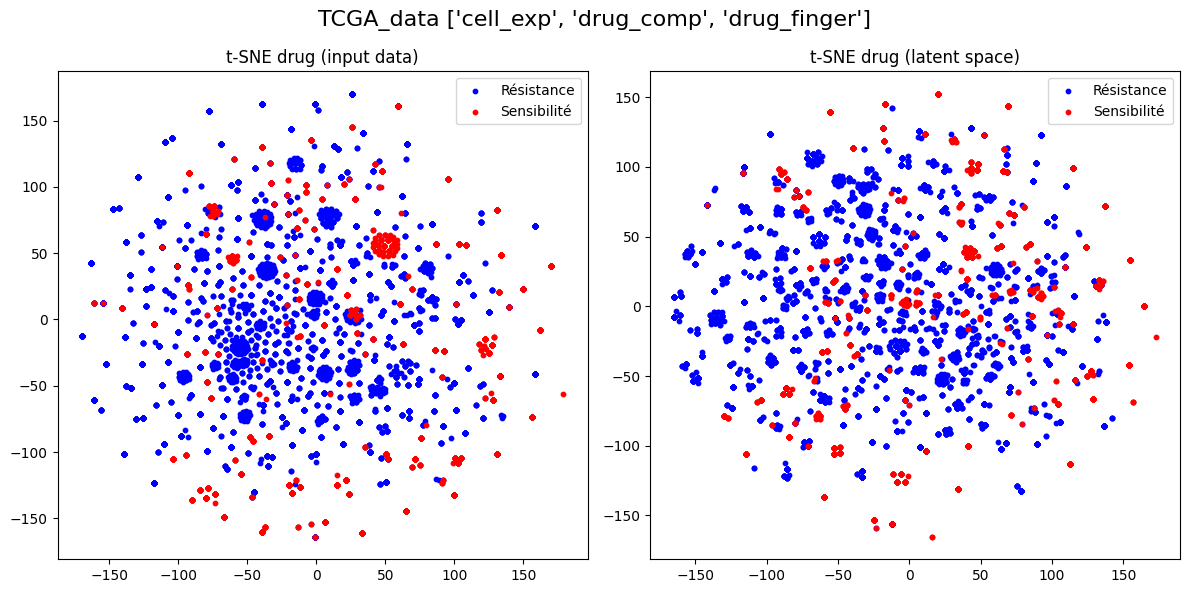

In [9]:
# Visualiser les résultats

plt.figure(figsize=(12, 6))

# Ajouter un titre
plt.suptitle("TCGA_data ['cell_exp', 'drug_comp', 'drug_finger']", fontsize=16)

# Sous-figure pour la projection t-SNE sur les données d'entrée
plt.subplot(1, 2, 1)
for class_value, color, label in zip([0, 1], ['blue', 'red'], ['Résistance', 'Sensibilité']):
    mask = (Y == class_value)
    plt.scatter(
        X_tsne_input[mask, 0],
        X_tsne_input[mask, 1],
        c=color,
        s=10,
        label=label
    )
plt.title("t-SNE drug (input data)")
plt.legend()


# Sous-figure pour la projection t-SNE sur l'espace latent
plt.subplot(1, 2, 2)
for class_value, color, label in zip([0, 1], ['blue', 'red'], ['Résistance', 'Sensibilité']):
    mask = (Y == class_value)
    plt.scatter(
        X_tsne_latent[mask, 0],
        X_tsne_latent[mask, 1],
        c=color,
        s=10,
        label=label
    )
plt.title("t-SNE drug (latent space)")
plt.legend()

plt.tight_layout()
plt.show()